### Getting started tutorial
http://edwardlib.org/getting-started
http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import edward as ed
from edward.models import Normal

sess = ed.get_session()
tf.global_variables_initializer().run()

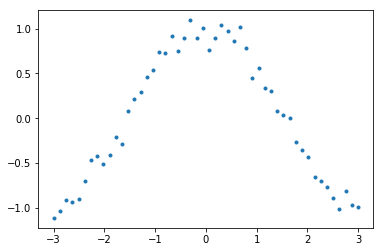

In [17]:
# generate training data
N = 50
x_train = np.linspace(-3, 3, num=N)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype('float32').reshape((N, 1))
y_train = y_train.astype('float32').reshape((N, 1))

plt.plot(x_train, y_train, '.')

In [18]:
# two layer feed-forward neural net
def ffnet(x, W0, b0, W1, b1):
    return tf.matmul(tf.tanh(tf.matmul(x, W0) + b0), W1) + b1

W0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2])) # one input -> two hidden units
b0 = Normal(loc=tf.zeros(2), scale=tf.ones(2)) # bias for two hiddin units

W1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1])) # two hidden units -> one output unit
b1 = Normal(loc=tf.zeros(1), scale=tf.ones(1)) # bias for output unit

y = Normal(loc=ffnet(x_train, W0, b0, W1, b1), scale=tf.constant(0.1))

In [19]:
# variational inference
qW0 = Normal(loc=tf.Variable(tf.zeros([1, 2])), scale=tf.nn.softplus(tf.Variable(tf.zeros([1, 2]))))
qW1 = Normal(loc=tf.Variable(tf.zeros([2, 1])), scale=tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))
qb0 = Normal(loc=tf.Variable(tf.zeros(2)), scale=tf.nn.softplus(tf.Variable(tf.zeros(2))))
qb1 = Normal(loc=tf.Variable(tf.zeros(1)), scale=tf.nn.softplus(tf.Variable(tf.zeros(1))))

inference = ed.KLqp({W0: qW0, b0: qb0, W1: qW1, b1: qb1}, data={y: y_train})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: -18.711


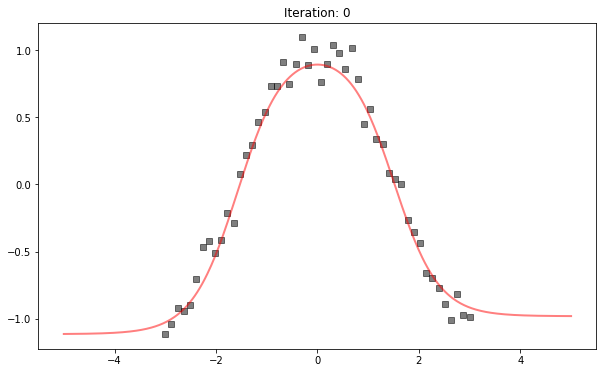

In [20]:
# visualize samples of inferred network
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [ffnet(x, qW0.sample(), qb0.sample(), qW1.sample(), qb1.sample())
     for _ in range(10)])
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0], 'r', lw=2, alpha=0.5, label='prior draws')
